<a href="https://colab.research.google.com/github/Ace007-0/Kimi-K2-from-scratch/blob/main/Kimi-K2-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets torch matplotlib tqdm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import torch
import re

# 100k TinyStories
dataset = load_dataset("roneneldan/TinyStories", split="train[:100000]")
texts = dataset["text"]
full_text = "\n\n".join(texts)

# Word-level tokenizer
def word_tokenize(text):
    return re.findall(r"\w+|[^\w\s]", text.lower())

words = word_tokenize(full_text)
vocab = sorted(set(words))
stoi = {w: i for i, w in enumerate(vocab)}
itos = {i: w for w, i in stoi.items()}
vocab_size = len(vocab)

def encode(text): return [stoi[w] for w in word_tokenize(text) if w in stoi]
def decode(tokens): return ' '.join([itos[i] for i in tokens])

data = torch.tensor(encode(full_text), dtype=torch.long)
split = int(0.9 * len(data))
train_data, val_data = data[:split], data[split:]

def get_batch(split, block_size=64, batch_size=32):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x, y


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SwiGLU(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=-1)
        return x1 * F.silu(x2)

class MuonClip(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0.01, clip_thresh=1.0):
        defaults = dict(lr=lr, weight_decay=weight_decay, clip_thresh=clip_thresh)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad
                grad_norm = grad.norm()
                if grad_norm > group['clip_thresh']:
                    grad = grad * (group['clip_thresh'] / grad_norm)
                if group['weight_decay'] != 0:
                    grad += group['weight_decay'] * p.data
                p.data.add_(grad, alpha=-group['lr'])

class MoELayer(nn.Module):
    def __init__(self, d_model, d_ff, n_experts=4, k=2):
        super().__init__()
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_ff * 2),
                SwiGLU(),
                nn.Linear(d_ff, d_model)
            ) for _ in range(n_experts)
        ])
        self.router = nn.Linear(d_model, n_experts)
        self.k = k

    def forward(self, x):
        B, T, C = x.shape
        scores = self.router(x)
        topk = torch.topk(scores, self.k, dim=-1)
        out = torch.zeros_like(x)
        for i in range(self.k):
            expert_idx = topk.indices[..., i]
            weight = torch.softmax(topk.values[..., i], dim=-1).unsqueeze(-1)
            for j, expert in enumerate(self.experts):
                mask = (expert_idx == j).float().unsqueeze(-1)
                out += weight * mask * expert(x)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.moe = MoELayer(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        B, T, C = x.shape
        mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(x.device)
        attn_out, _ = self.attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout(attn_out))
        moe_out = self.moe(x)
        return self.norm2(x + self.dropout(moe_out))

class NanoKimi(nn.Module):
    def __init__(self, vocab_size, block_size=256, d_model=512, n_heads=8, d_ff=1024, n_layers=6, dropout=0.1):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(block_size, d_model)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[TransformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        token_emb = self.token_embed(x)
        pos = self.pos_embed(torch.arange(T, device=x.device))
        x = self.dropout(token_emb + pos)
        x = self.blocks(x)
        x = self.norm(x)
        return self.output_head(x)


  0%|          | 1/2000 [00:02<1:09:59,  2.10s/it]

Step 0 | Loss: 9.9795


  5%|▌         | 101/2000 [02:26<46:27,  1.47s/it]

Step 100 | Loss: 9.8881


 10%|█         | 201/2000 [04:55<44:43,  1.49s/it]

Step 200 | Loss: 9.7421


 15%|█▌        | 301/2000 [07:23<42:03,  1.49s/it]

Step 300 | Loss: 9.5611


 20%|██        | 401/2000 [09:52<39:44,  1.49s/it]

Step 400 | Loss: 9.2853


 25%|██▌       | 501/2000 [12:20<37:04,  1.48s/it]

Step 500 | Loss: 8.8444


 30%|███       | 601/2000 [14:49<34:41,  1.49s/it]

Step 600 | Loss: 8.4441


 35%|███▌      | 701/2000 [17:17<32:08,  1.48s/it]

Step 700 | Loss: 8.1645


 40%|████      | 801/2000 [19:46<29:37,  1.48s/it]

Step 800 | Loss: 7.8752


 45%|████▌     | 901/2000 [22:14<27:17,  1.49s/it]

Step 900 | Loss: 7.6542


 50%|█████     | 1001/2000 [24:42<24:38,  1.48s/it]

Step 1000 | Loss: 7.5287


 55%|█████▌    | 1101/2000 [27:11<22:12,  1.48s/it]

Step 1100 | Loss: 7.4583


 60%|██████    | 1201/2000 [29:39<19:44,  1.48s/it]

Step 1200 | Loss: 7.3545


 65%|██████▌   | 1301/2000 [32:07<17:15,  1.48s/it]

Step 1300 | Loss: 7.2570


 70%|███████   | 1401/2000 [34:35<14:47,  1.48s/it]

Step 1400 | Loss: 7.2169


 75%|███████▌  | 1501/2000 [37:04<12:21,  1.49s/it]

Step 1500 | Loss: 7.1037


 80%|████████  | 1601/2000 [39:32<09:51,  1.48s/it]

Step 1600 | Loss: 7.0491


 85%|████████▌ | 1701/2000 [42:00<07:22,  1.48s/it]

Step 1700 | Loss: 6.9968


 90%|█████████ | 1801/2000 [44:28<04:54,  1.48s/it]

Step 1800 | Loss: 6.9135


 95%|█████████▌| 1901/2000 [46:56<02:26,  1.48s/it]

Step 1900 | Loss: 6.8686


100%|██████████| 2000/2000 [49:23<00:00,  1.48s/it]


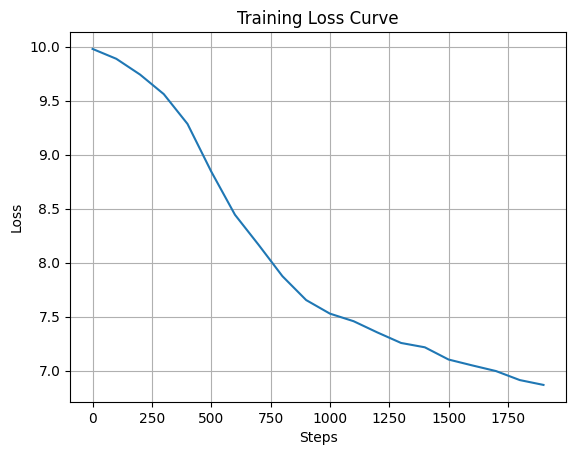

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
block_size = 256
batch_size = 32
steps = 2000
eval_interval = 100

model = NanoKimi(vocab_size, block_size=block_size).to(device)
optimizer = MuonClip(model.parameters(), lr=1e-3, weight_decay=1e-2)

losses = []

for step in tqdm(range(steps)):
    model.train()
    xb, yb = get_batch("train", block_size, batch_size)
    xb, yb = xb.to(device), yb.to(device)

    logits = model(xb)
    loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % eval_interval == 0:
        print(f"Step {step} | Loss: {loss.item():.4f}")
        losses.append(loss.item())

# Plot training loss
plt.plot(range(0, steps, eval_interval), losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [5]:
def generate(model, prompt, max_new_tokens=100, temperature=1.0, top_k=20, repetition_penalty=1.2):
    model.eval()
    input_ids = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(input_ids[:, -block_size:])
            logits = logits[:, -1, :] / temperature
            for token_id in set(input_ids[0].tolist()):
                logits[0, token_id] /= repetition_penalty
            top_k_logits, top_k_indices = torch.topk(logits, k=top_k, dim=-1)
            probs = F.softmax(top_k_logits, dim=-1)
            next_token = top_k_indices.gather(-1, torch.multinomial(probs, 1))
            input_ids = torch.cat([input_ids, next_token], dim=1)

    return decode(input_ids[0].tolist())

print(generate(model, "Once upon a time", max_new_tokens=100))


once upon a time they to and he it was she , the " . and and that and his , . it a a " her he , , ' it . and so . a the " they ! the to was the he they . was , . and and . it " she in and a . she and the said to her it was . . . . and the , they the he you it and , the . ! the to ! they her and ' a a and . and the and was the , "


In [6]:
print(generate(model, "One day, a little girl named Lily ", max_new_tokens=100))

one day , a little girl named lily . and ' she it he . " the and and said it , " to the was of they " . the was and her the " the you ! she a they " she . a to they . in the . . to ! a , so , and to was it to she , . the she in the it . and . she , he his . and . they they . and a to . . . " . . " and it , " a a , her her and . he .


In [7]:
print(generate(model, "Lily ", max_new_tokens=100))

lily . she they he and " the , the and to ! . it , her . the " . you was a to they the . " , " . she , ! he that of . she ! her said , the and it . she . ' it her and her the and he the the . and the a , it . . a , . . . " the a in a ' they was . ! and the in to . " the he , and the his a the the was the and


In [9]:
print(generate(model, "Once upon a time, there was a little car named", max_new_tokens=100))

once upon a time , there was a little car named . and the to it she ' lily , they and . . . he . " , that " was of and the ' and a in a was in and the was the they and , . so to he , " . . they ' , " and her " her to was she . a the the was he to , a the to ! he , it to , ! they they a his . to her was " and , a , the , he had a a . you she he a she
